In [1]:
%load_ext autoreload
%autoreload 2

In [97]:
import sys
sys.path.append('/home/xhding/workspaces/torch-deep-retina')
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import h5py
from  torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from scipy.stats import pearsonr
from scipy.special import factorial
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from fnn.evaluation import *
from fnn.utils import select_model
from fnn.config import get_custom_cfg
from fnn.data import TestDataset, ValidationDataset
from fnn.distributions import *
from fnn.notebook.utils import *
from torchdeepretina.datas import loadexpt
from torchdeepretina.pyret_func import estfr
import pyret

In [4]:
file_path = '/home/xhding/tem_stim/21-03-15/naturalscene.h5'
cells = [0,1,2,3,4,6]
t_list = [3,3,3,3,2,3]
recording = recording_stats(file_path, cells)
recording_cut = recording_stats(file_path, cells, truncate=True, t_list=t_list)
single_trial_bin = recording.single_trial_bin
single_trial_bin_cut = recording_cut.single_trial_bin

In [5]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_try')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-3.54_pearson_0.6845.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=10000)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 6, device, cfg)

(0.8618577671956162, 0.633123748436763, 0.22873401875885324)


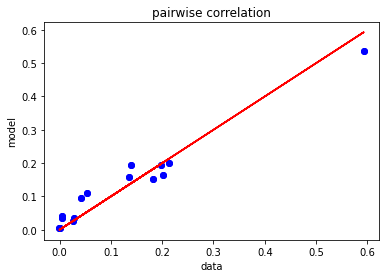

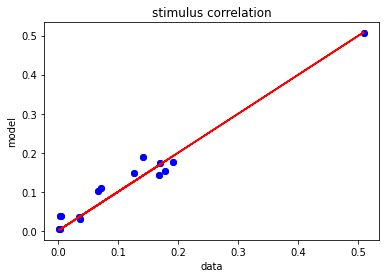

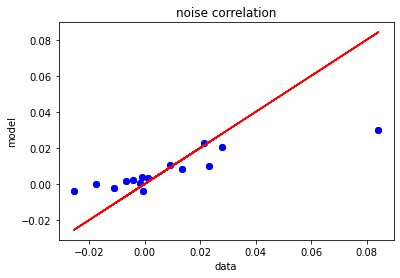

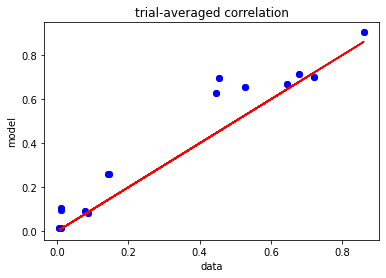

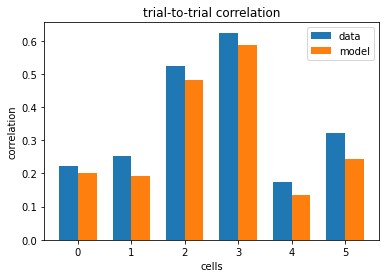

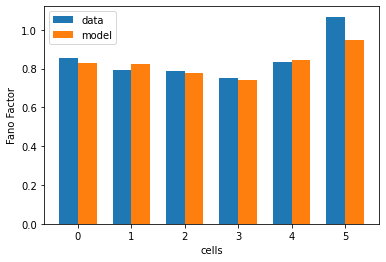

In [162]:
binomial_para = [2.17, 2.85, 2.5, 2.5, 1.0, 0.47]
pred_single_trial = model_single_trial(model, test_data, device, t_list, binomial_para, pred, recording, gaussian=[0, 0, 0.3, 0], seed1=81, seed2=213)
print(error_corr(single_trial_bin, pred_single_trial))
correlation_plot(single_trial_bin, pred_single_trial)

In [78]:
optimum_para = {}
optimum_para['gaussian'] = [0.61, 0.56, 0.56, 0.58, 1., 1.22]
optimum_para['poisson1'] = [5.56, 8.87, 4.65, 3.80, 1., 0.83]
optimum_para['poisson2'] = [3.81, 5.03, 3.30, 2.92, 6.10, 0.61]
optimum_para['binomial'] = [2.17, 2.85, 1.91, 1.69, 1., 0.47]

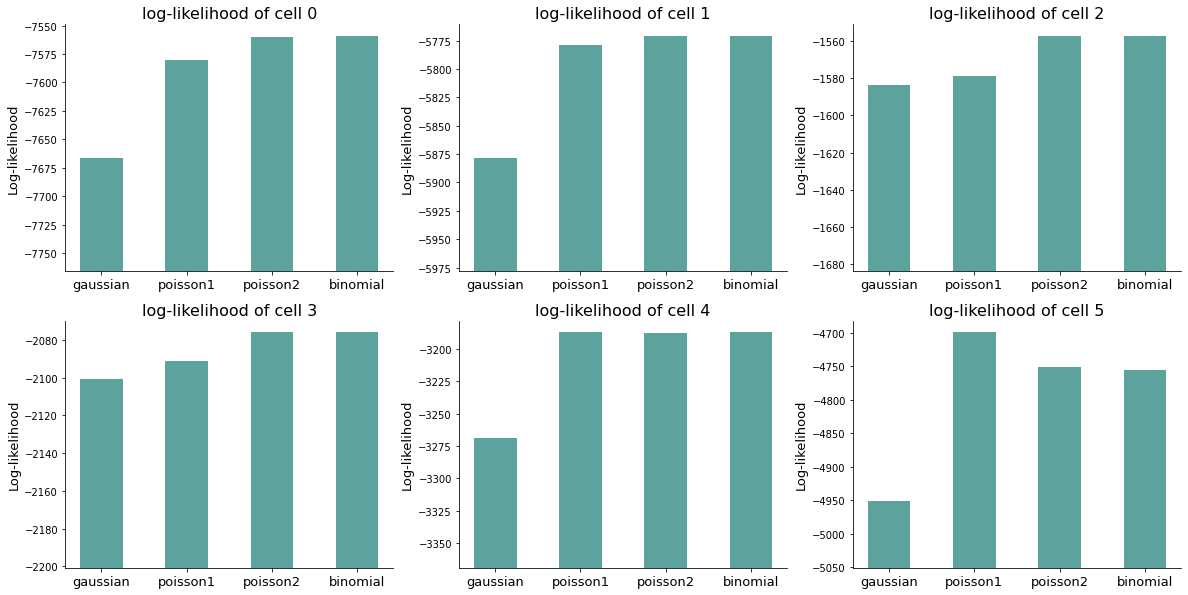

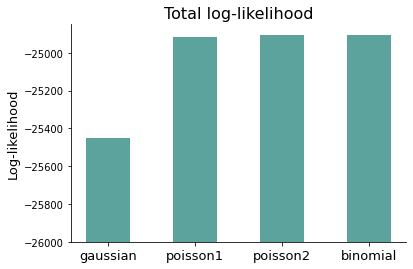

In [80]:
lls = log_likelihood(recording_cut, t_list, optimum_para)
log_likelihood_plot(lls)
log_likelihood_plot(lls, mean=True)

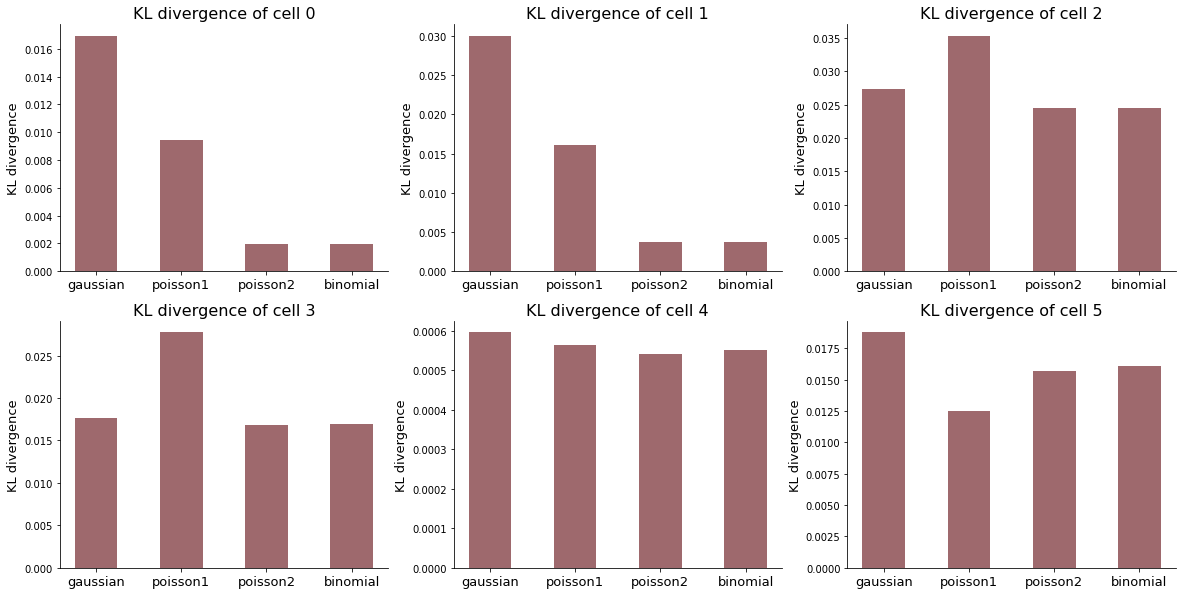

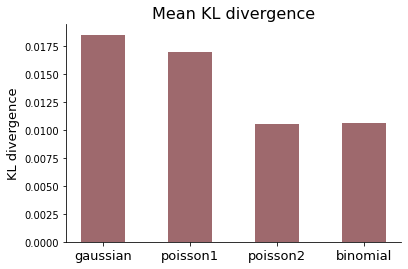

In [79]:
kls = kullback_leibler(recording_cut, t_list, optimum_para)
kullback_leibler_plot(kls)
kullback_leibler_plot(kls, mean=True)

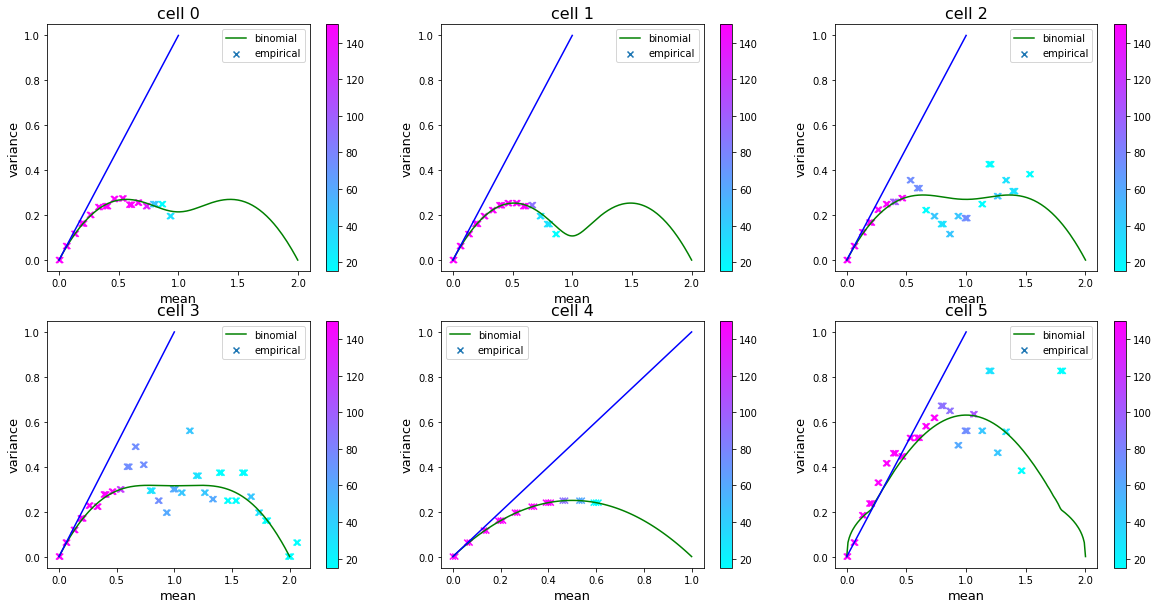

In [61]:
variance_mean_plot(recording, t_list, optimum_para)

In [161]:
binomial_para = [2.17, 2.85, 2.5, 2.5, 1.0, 0.47]
min_error = 10
for i in range(0,100):
    pred_single_trial = model_single_trial(model, test_data, device, t_list, binomial_para, pred, recording, gaussian=[0, 0, 0.3, 0], seed1=i, seed2=213, thre=3)
    error = error_corr(single_trial_bin, pred_single_trial)[1]
    if error < min_error:
        min_error = error
        min_seed = i
print(min_seed, min_error)

81 0.633123748436763


In [160]:
binomial_para = [2.17, 2.85, 2.5, 2.5, 1.0, 0.47]
min_error = 10
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0, 0, 0.3, 0], 213)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
for i in range(200):
    pred_single_trial = model_single_trial_post(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, 3, i)
    error = error_corr(single_trial_bin, pred_single_trial)[1]
    if error < min_error:
        min_error = error
        min_seed = i
print(min_seed, min_error)

32 0.6941440541875643


In [171]:
binomial_para = [2.17, 2.85, 2.5, 2.5, 1.0, 0.47]
min_error = 10
for i in range(0,200):
    pred_single_trial = model_single_trial(model, test_data, device, t_list, binomial_para, pred, recording, gaussian=[0, 0, 0.3, 0], seed1=i, seed2=i, thre=3)
    error = error_corr(single_trial_bin, pred_single_trial, [15,20])[1]
    if error < min_error:
        min_error = error
        min_seed = i
print(min_seed, min_error)

98 0.7002045860445859


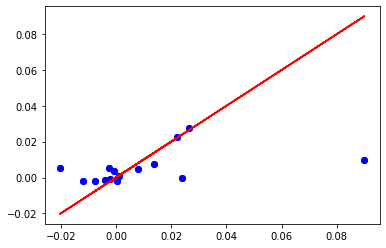

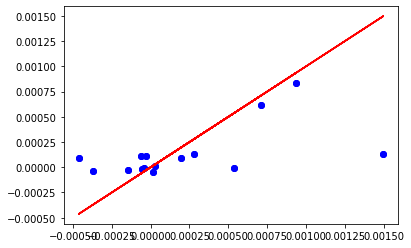

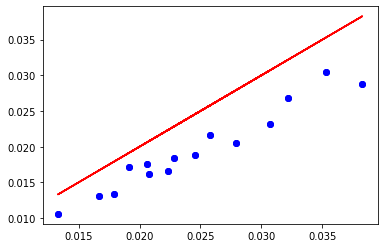

In [175]:
def noise_corr_try(single_trial):
    noise = single_trial - single_trial.mean(0)
    cov_noise = (np.expand_dims(noise, -1) * np.expand_dims(noise, -2)).mean((0,1))
    V = ((single_trial - single_trial.mean((0,1)))**2).mean((0,1))
    denom = np.sqrt(np.expand_dims(V, -1) * np.expand_dims(V, -2))
    noise_corr = cov_noise / denom
    return noise_corr, cov_noise, denom

diagonal_idxs = list(range(0, 36, 7))

a = np.delete(noise_corr_try(single_trial_bin)[0].flatten(), diagonal_idxs)
b = np.delete(noise_corr_try(pred_single_trial)[0].flatten(), diagonal_idxs)
plt.plot(a, b, 'bo')
plt.plot(a, a, 'r-')
plt.show()

a = np.delete(noise_corr_try(single_trial_bin)[1].flatten(), diagonal_idxs)
b = np.delete(noise_corr_try(pred_single_trial)[1].flatten(), diagonal_idxs)
plt.plot(a, b, 'bo')
plt.plot(a, a, 'r-')
plt.show()

a = np.delete(noise_corr_try(single_trial_bin)[2].flatten(), diagonal_idxs)
b = np.delete(noise_corr_try(pred_single_trial)[2].flatten(), diagonal_idxs)
plt.plot(a, b, 'bo')
plt.plot(a, a, 'r-')
plt.show()

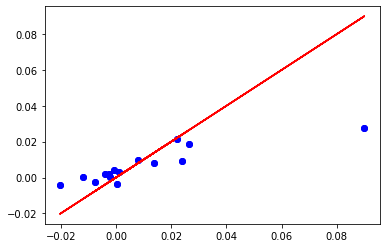

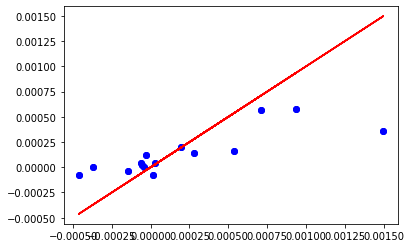

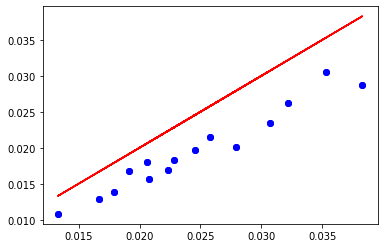

In [176]:
pred_single_trial = model_single_trial(model, test_data, device, t_list, binomial_para, pred, recording, gaussian=[0, 0, 0.3, 0], seed1=81, seed2=213)

a = np.delete(noise_corr_try(single_trial_bin)[0].flatten(), diagonal_idxs)
b = np.delete(noise_corr_try(pred_single_trial)[0].flatten(), diagonal_idxs)
plt.plot(a, b, 'bo')
plt.plot(a, a, 'r-')
plt.show()

a = np.delete(noise_corr_try(single_trial_bin)[1].flatten(), diagonal_idxs)
b = np.delete(noise_corr_try(pred_single_trial)[1].flatten(), diagonal_idxs)
plt.plot(a, b, 'bo')
plt.plot(a, a, 'r-')
plt.show()

a = np.delete(noise_corr_try(single_trial_bin)[2].flatten(), diagonal_idxs)
b = np.delete(noise_corr_try(pred_single_trial)[2].flatten(), diagonal_idxs)
plt.plot(a, b, 'bo')
plt.plot(a, a, 'r-')
plt.show()

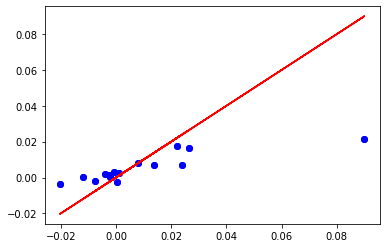

In [178]:
a = np.delete(noise_corr_try(single_trial_bin)[1].flatten(), diagonal_idxs)/np.delete(noise_corr_try(single_trial_bin)[2].flatten(), diagonal_idxs)
b = np.delete(noise_corr_try(pred_single_trial)[1].flatten(), diagonal_idxs)/np.delete(noise_corr_try(single_trial_bin)[2].flatten(), diagonal_idxs)
plt.plot(a, b, 'bo')
plt.plot(a, a, 'r-')
plt.show()

In [187]:
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, gaussian=[0, 0, 0.3, 0], seed=81)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
pred_scales = np.zeros(pred_single_trial_pre.shape)
for cell in range(6):
    pred_scale = np.polyval(poly_paras[cell], pred_single_trial_pre[:, :, cell]/100)*100
    pred_scales[:,:,cell] = pred_scale

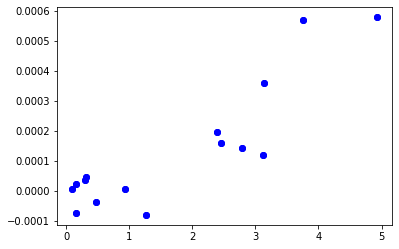

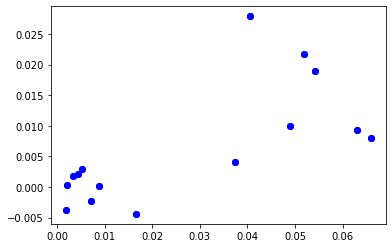

In [188]:
b = np.delete(noise_corr_try(pred_single_trial)[1].flatten(), diagonal_idxs)
c = np.delete(noise_corr_try(pred_scales)[1].flatten(), diagonal_idxs)
plt.plot(c, b, 'bo')
plt.show()

b = np.delete(noise_corr_try(pred_single_trial)[0].flatten(), diagonal_idxs)
c = np.delete(noise_corr_try(pred_scales)[0].flatten(), diagonal_idxs)
plt.plot(c, b, 'bo')
plt.show()

In [48]:
binomial_para = [2.17, 2.85, 2.5, 2.5, 1.0, 0.47]
error_stats_all = []
for i in range(0,100):
    pred_single_trial = model_single_trial(model, test_data, device, t_list, binomial_para, pred, recording, gaussian=[0, 0, 0.3, 0], seed1=i, seed2=i, thre=3)
    error1 = error_corr(single_trial_bin, pred_single_trial)[0]
    error2 = error_corr(single_trial_bin, pred_single_trial, [15,20])[0]
    error_stats_all.append((i, error1, error2))

In [49]:
binomial_para = [2.17, 2.85, 2.5, 2.5, 1.0, 0.47]
error_stats_post = []
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0, 0, 0.3, 0], 81)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
for i in range(100):
    pred_single_trial = model_single_trial_post(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, 3, i)
    error1 = error_corr(single_trial_bin, pred_single_trial)[0]
    error2 = error_corr(single_trial_bin, pred_single_trial, [15,20])[0]
    error_stats_post.append((i, error1, error2))

In [50]:
binomial_para = [2.17, 2.85, 2.5, 2.5, 1.0, 0.47]
error_stats_pre = []
for i in range(100):
    pred_single_trial = model_single_trial(model, test_data, device, t_list, binomial_para, pred, recording, gaussian=[0, 0, 0.3, 0], seed1=i, seed2=213, thre=3)
    error1 = error_corr(single_trial_bin, pred_single_trial)[0]
    error2 = error_corr(single_trial_bin, pred_single_trial, [15,20])[0]
    error_stats_pre.append((i, error1, error2))

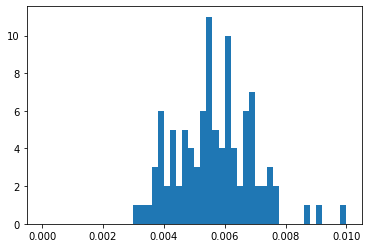

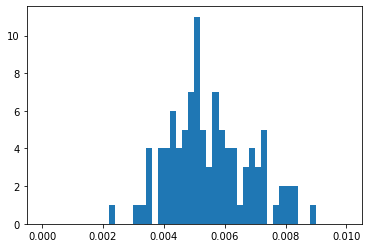

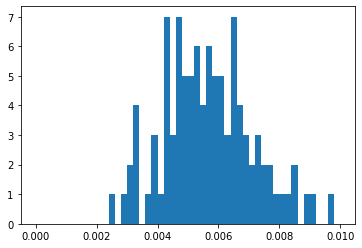

In [69]:
plt.hist(np.array(error_stats_all)[:,2], bins=50, range=(0,0.01))
plt.show()
plt.hist(np.array(error_stats_post)[:,2], bins=50, range=(0,0.01))
plt.show()
plt.hist(np.array(error_stats_pre)[:,2], bins=50, range=(0,0.01))
plt.show()

(0.010848111550018233, 0.6566789516901316, 0.20939637185125606)


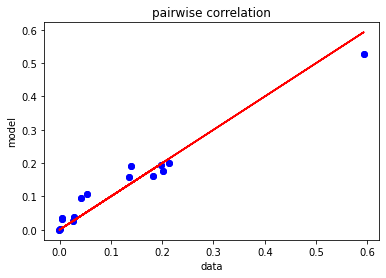

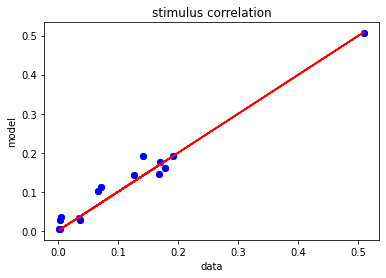

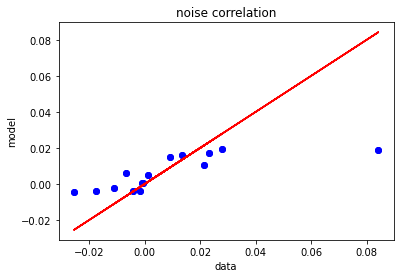

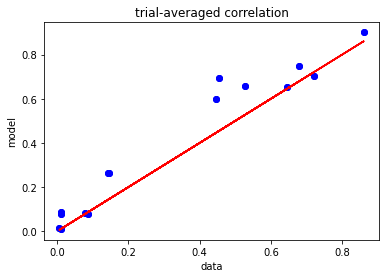

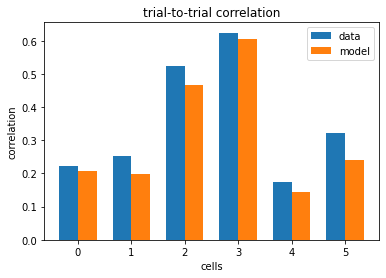

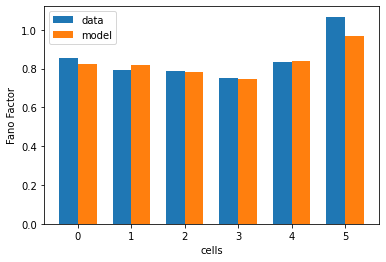

In [65]:
binomial_para = [2.17, 2.85, 2.5, 2.5, 1.0, 0.47]
pred_single_trial = model_single_trial(model, test_data, device, t_list, binomial_para, pred, recording, gaussian=[0, 0, 0.3, 0], seed1=81, seed2=98)
print(error_corr(single_trial_bin, pred_single_trial))
correlation_plot(single_trial_bin, pred_single_trial)

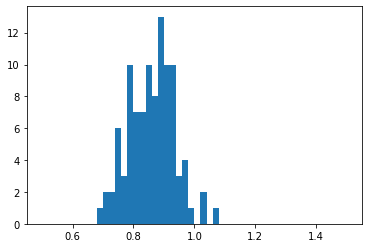

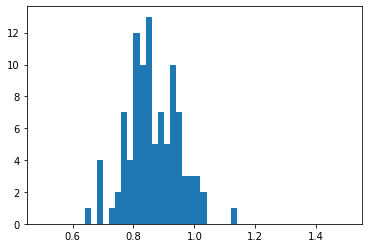

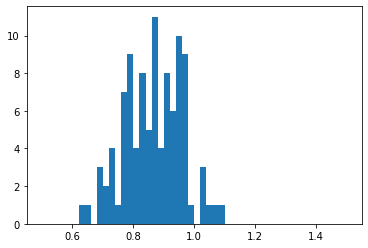

In [12]:
plt.hist(np.array(error_stats_all)[:,1], bins=50, range=(0.5,1.5))
plt.show()
plt.hist(np.array(error_stats_post)[:,1], bins=50, range=(0.5,1.5))
plt.show()
plt.hist(np.array(error_stats_pre)[:,1], bins=50, range=(0.5,1.5))
plt.show()

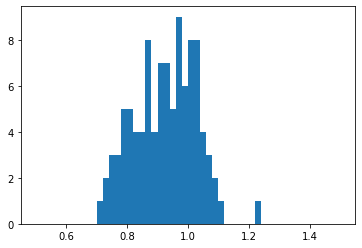

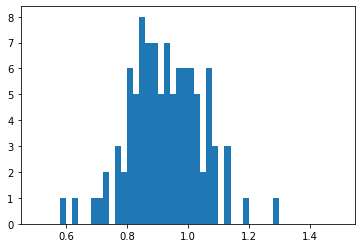

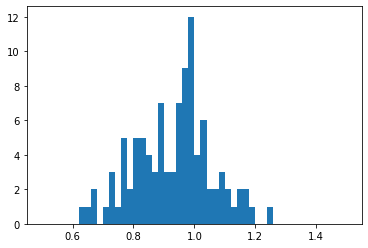

In [13]:
plt.hist(np.array(error_stats_all)[:,2], bins=50, range=(0.5,1.5))
plt.show()
plt.hist(np.array(error_stats_post)[:,2], bins=50, range=(0.5,1.5))
plt.show()
plt.hist(np.array(error_stats_pre)[:,2], bins=50, range=(0.5,1.5))
plt.show()

In [78]:
import time

In [80]:
binomial_para = [2.17, 2.85, 2.5, 2.5, 1.0, 0.47]
error_stats_post = []
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0, 0, 0.3, 0], 81)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
n_repeats = 5
pred_concat = []
start = time.time()
for n in range(n_repeats):
    each_pred = model_single_trial_post(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, 3)
    pred_concat.append(each_pred)
pred_concat = np.concatenate(pred_concat)

for i in range(100):
    np.random.seed(i)
    idxs = np.random.choice(range(15*n_repeats), 15, False)
    pred_single_trial = pred_concat[idxs]
    error = error_corr(single_trial_bin, pred_single_trial, [15,20])[0]
end = time.time()
print(end-start)

288.21603202819824


In [81]:
start = time.time()
for i in range(100):
    pred_single_trial = model_single_trial_post(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, 3, i)
    error = error_corr(single_trial_bin, pred_single_trial, [15,20])[0]
end = time.time()
print(end-start)

932.6312081813812


In [83]:
n_repeats = 5
pred_concat = []
start = time.time()
for n in range(n_repeats):
    each_pred = model_single_trial_post(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, 3)
    pred_concat.append(each_pred)
pred_concat = np.concatenate(pred_concat)

for i in range(100):
    np.random.seed(i)
    idxs = np.random.choice(range(15*n_repeats), 15, False)
    pred_single_trial = pred_concat[idxs]
    error = error_corr2(single_trial_bin, pred_single_trial, [15,20])
end = time.time()
print(end-start)

37.794859886169434


In [86]:
n_repeats = 5
pred_concat = []
start = time.time()
for n in range(n_repeats):
    each_pred = model_single_trial_post(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, 3)
    pred_concat.append(each_pred)
pred_concat = np.concatenate(pred_concat)

for i in range(100):
    np.random.seed(i)
    idxs = np.random.choice(range(15*n_repeats), 15, False)
    pred_single_trial = pred_concat[idxs]
    error = error_corr3(single_trial_bin, pred_single_trial, [15,20])
end = time.time()
print(end-start)

331.07724499702454


In [135]:
n_repeats = 5
pred_concat = []
start = time.time()
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred)

for i in range(100):
    np.random.seed(i)
    idxs = np.random.choice(range(n_repeats), 15, True)
    pred_single_trial = pred_single_trial_multi[idxs, np.arange(15)]
    error = error_corr2(single_trial_bin, pred_single_trial, [15,20])
end = time.time()
print(end-start)

9.61166524887085


In [136]:
start = time.time()
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100)

for i in range(100):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial, [15,20])
end = time.time()
print(end-start)

12.628585577011108


In [113]:
binomial_para = [2.17, 2.85, 2.5, 2.5, 1.0, 0.47]
error_stats_post = []
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0, 0, 0.3, 0], 81)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
n_repeats = 5
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred)

error_stats_draw = []
for i in range(100):
    np.random.seed(i)
    idxs = np.random.choice(range(n_repeats), 15, True)
    pred_single_trial = pred_single_trial_multi[idxs, np.arange(15)]
    error = error_corr2(single_trial_bin, pred_single_trial, [15,20])
    error_stats_draw.append((i, error))

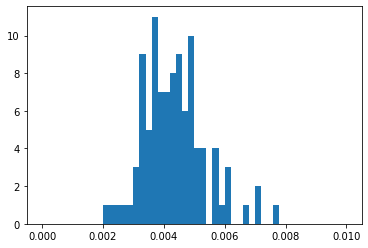

In [115]:
plt.hist(np.array(error_stats_draw)[:,1], bins=50, range=(0.,0.01))
plt.show()

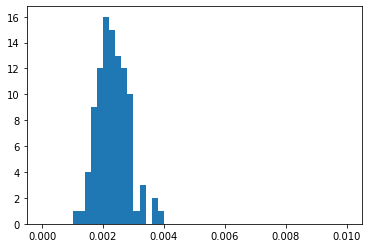

In [117]:
error_stats_draw_stats = []
for seed in range(100):
    binomial_para = [2.17, 2.85, 2.5, 2.5, 1.0, 0.47]
    error_stats_post = []
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0, 0, 0.3, 0], seed)
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    n_repeats = 5
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred)
    
    min_error = 10
    
    for i in range(100):
        np.random.seed(i)
        idxs = np.random.choice(range(n_repeats), 15, True)
        pred_single_trial = pred_single_trial_multi[idxs, np.arange(15)]
        error = error_corr2(single_trial_bin, pred_single_trial, [15,20])
        if error < min_error:
            min_error = error
    error_stats_draw_stats.append((seed, min_error))
    
plt.hist(np.array(error_stats_draw_stats)[:,1], bins=50, range=(0.,0.01))
plt.show()

In [121]:
binomial_para = [2.17, 2.85, 2.5, 2.5, 1.0, 0.47]
error_stats_post = []
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0, 0, 0.3, 0], 25)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
n_repeats = 5
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred)

min_error = 10
for i in range(100):
    np.random.seed(i)
    idxs = np.random.choice(range(n_repeats), 15, True)
    pred_single_trial = pred_single_trial_multi[idxs, np.arange(15)]
    error = error_corr2(single_trial_bin, pred_single_trial, [15,20])
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial

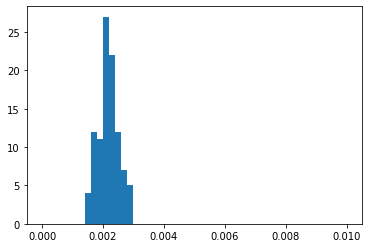

In [137]:
error_stats_draw_stats = []
for seed in range(100):
    binomial_para = [2.17, 2.85, 2.5, 2.5, 1.0, 0.47]
    error_stats_post = []
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0, 0, 0.3, 0], seed)
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=seed)
    
    min_error = 10
    
    for i in range(100):
        pred_single_trial = pred_single_trial_multi[i]
        error = error_corr2(single_trial_bin, pred_single_trial, [15,20])
        if error < min_error:
            min_error = error
    error_stats_draw_stats.append((seed, min_error))
    
plt.hist(np.array(error_stats_draw_stats)[:,1], bins=50, range=(0.,0.01))
plt.show()

In [138]:
from scipy.stats import norm
mean,std=norm.fit(np.array(error_stats_draw_stats)[:,1])

In [139]:
mean,std

(0.0021764431163063588, 0.00032702665629538236)

In [140]:
np.where(np.array(error_stats_draw_stats)[:,1]==np.array(error_stats_draw_stats)[:,1].min())

(array([42]),)

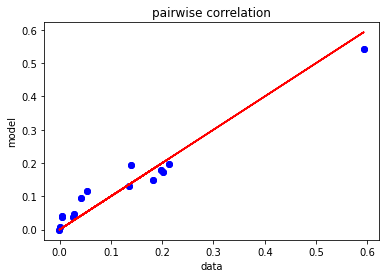

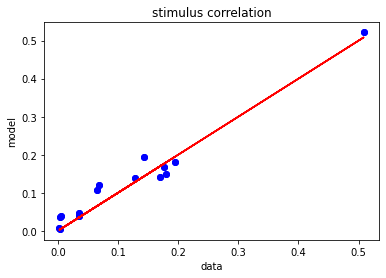

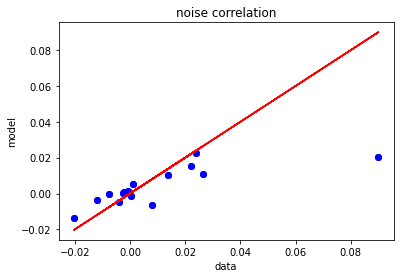

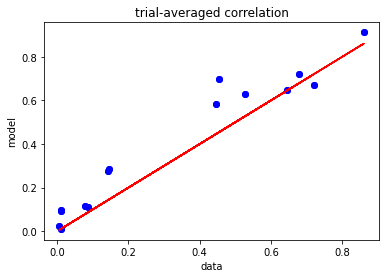

In [142]:
binomial_para = [2.17, 2.85, 2.5, 2.5, 1.0, 0.47]
error_stats_post = []
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0, 0, 0.3, 0], 42)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=42)

min_error = 10
for i in range(100):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial, [15,20])
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)

In [145]:
for g2 in np.linspace(0,0.5,51):
    binomial_para = [2.17, 2.85, 2.5, 2.5, 1.0, 0.47]
    error_stats_post = []
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0, 0, g2, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100)
    
    min_error = 10
    
    for i in range(100):
        pred_single_trial = pred_single_trial_multi[i]
        error = error_corr2(single_trial_bin, pred_single_trial, [15,20])
        if error < min_error:
            min_error = error
    print(g2, min_error)

0.0 0.0026767191232029866
0.01 0.00379929565718566
0.02 0.0025910379925624793
0.03 0.0028027402974009283
0.04 0.0029465585426907037
0.05 0.002103047366347192
0.06 0.003405014227937059
0.07 0.002996839197356241
0.08 0.002729458601708219
0.09 0.0029677350287148838
0.1 0.003561719262075936
0.11 0.0024514820353871676
0.12 0.0037211271960230423
0.13 0.002954671316476339
0.14 0.0027002902635107585
0.15 0.002851186955367894
0.16 0.0027858411142631123
0.17 0.0026333551700010284
0.18 0.002809342935483532
0.19 0.0022988734125150745
0.2 0.0026680296910328296
0.21 0.002066153065412874
0.22 0.0026566449558155917
0.23 0.002293236354817488
0.24 0.002580884679304324
0.25 0.002388043050098847
0.26 0.002292528496724679
0.27 0.0024452358948835965
0.28 0.0013565502097720521
0.29 0.002783937552071065
0.3 0.0015927017617500573
0.31 0.002500314739389677
0.32 0.0018964144017335168
0.33 0.001880407450413195
0.34 0.0024956938491507877
0.35000000000000003 0.0025653664654673603
0.36 0.002150527575434383
0.37 0.00

In [146]:
for g1 in np.linspace(0,0.5,51):
    binomial_para = [2.17, 2.85, 2.5, 2.5, 1.0, 0.47]
    error_stats_post = []
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0, g1, 0, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100)
    
    min_error = 10
    
    for i in range(100):
        pred_single_trial = pred_single_trial_multi[i]
        error = error_corr2(single_trial_bin, pred_single_trial, [15,20])
        if error < min_error:
            min_error = error
    print(g1, min_error)

0.0 0.0024269003900692066
0.01 0.0036936024274865486
0.02 0.003454548116208698
0.03 0.0032126099788780337
0.04 0.0034703256554336715
0.05 0.0019897236895758006
0.06 0.0031798128911038944
0.07 0.003296151641712595
0.08 0.0030392197555612938
0.09 0.0033912308872065065
0.1 0.002734552178387869
0.11 0.0031316891002535797
0.12 0.0027518429566778875
0.13 0.002641572817815101
0.14 0.0030432001358766166
0.15 0.0026748635653879456
0.16 0.002927690744481203
0.17 0.002376738881699746
0.18 0.0025563895119490314
0.19 0.00308779537574256
0.2 0.002794835080656898
0.21 0.003568585153574308
0.22 0.004001680135982769
0.23 0.0035785541133726687
0.24 0.0038509182087527846
0.25 0.0039270554909445025
0.26 0.004331611858608862
0.27 0.0037038442288134304
0.28 0.0043976733790880625
0.29 0.002936695623732166
0.3 0.006213104997182117
0.31 0.005870556663060133
0.32 0.00532102130288262
0.33 0.00646216849892825
0.34 0.004782804996146159
0.35000000000000003 0.005616502099152096
0.36 0.005453348922109575
0.37 0.00710

In [147]:
for g0 in np.linspace(0,0.5,51):
    binomial_para = [2.17, 2.85, 2.5, 2.5, 1.0, 0.47]
    error_stats_post = []
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [g0, 0, 0, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100)
    
    min_error = 10
    
    for i in range(100):
        pred_single_trial = pred_single_trial_multi[i]
        error = error_corr2(single_trial_bin, pred_single_trial, [15,20])
        if error < min_error:
            min_error = error
    print(g0, min_error)

0.0 0.003577085312310566
0.01 0.003630728538817552
0.02 0.0030643402201251703
0.03 0.002778050385101277
0.04 0.0025853325724363814
0.05 0.0026387314254680714
0.06 0.0021734126518831456
0.07 0.003272523767907774
0.08 0.0032067735940218
0.09 0.0025764374340921407
0.1 0.0030841015189273027
0.11 0.003162918150671903
0.12 0.003339450075578272
0.13 0.0030299569419201347
0.14 0.002978552800528003
0.15 0.003450297941095822
0.16 0.0031589830746211454
0.17 0.0034730577155871337
0.18 0.003013457357940622
0.19 0.003309834572232868
0.2 0.0029268404444690813
0.21 0.0024414452004400755
0.22 0.0024815431153652934
0.23 0.0025858008956053846
0.24 0.0023154924049489014
0.25 0.003040922482530356
0.26 0.0034780463360924744
0.27 0.003283729748605375
0.28 0.003458099279892996
0.29 0.0022877295465710996
0.3 0.003088934706630407
0.31 0.0031693810487564583
0.32 0.003226816776168672
0.33 0.0033559863283566726
0.34 0.0025359948727648974
0.35000000000000003 0.003132365772820951
0.36 0.0028678924459764853
0.37 0.00

In [155]:
for g0 in np.linspace(1.5,2.,6):
    binomial_para = [2.17, 2.85, 2.5, 2.5, 1.0, 0.47]
    error_stats_post = []
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [g0, 0, 0, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100)
    
    min_error = 10
    
    for i in range(100):
        pred_single_trial = pred_single_trial_multi[i]
        error = error_corr2(single_trial_bin, pred_single_trial, [15,20])
        if error < min_error:
            min_error = error
    print(g0, min_error)

1.5 0.0037315490530756136
1.6 0.0033732626628361962
1.7 0.0029923341611170985
1.8 0.0038398046576456095
1.9 0.0037681651271574117
2.0 0.005752433428550237


In [ ]:
for g0 in np.linspace(1., 1.5, 6):
    binomial_para = [2.17, 2.85, 2.5, 2.5, 1.0, 0.47]
    error_stats_post = []
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [g0, 0, 0, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100)
    
    min_error = 10
    
    for i in range(100):
        pred_single_trial = pred_single_trial_multi[i]
        error = error_corr2(single_trial_bin, pred_single_trial, [15,20])
        if error < min_error:
            min_error = error
    print(g0, min_error)

1.0 0.002746788552935104
1.1 0.002727620164321096
1.2 0.0025974415643735026
1.3 0.002654057848961418
1.4 0.003625832289676327
